```plaintext

Long road, Two lanes, Different Vmax 
Add car when start point is empty 
Remove car at end point 

Ordered Rules:
1. Change lane
2. Change speed
    ·Check if need to boost
    ·Accelerate
    ·Slow down
    ·Random brake
3. Move

In [3]:
# model with density control
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import matplotlib.tri as tri

# dict to store different driver type(can also be used for reaction/...)
# make sure sapwn_weight sum up to 1
DRIVER_TYPES = {
    0: { # Lorry
        'vmax': 3,
        'overtake_rate': 0,    
        'return_rate': 1,
        'spawn_weight': 0.2,
        'boost_chance': 0.3,    # this can be used to simulate the need time for boost?(for example, 0.5 means average 2 timestep before boost)
        'boosted_vmax': 5,
        'random_brake_chance' : 0.3      
    },
    1: { # Regular Cars
        'vmax': 5,
        'overtake_rate': 0.5,    
        'return_rate': 0.5,     
        'spawn_weight': 0.6,
        'boost_chance': 0.3,   
        'boosted_vmax': 7,
        'random_brake_chance' : 0.3    
    },
    2: { # Fast Cars
        'vmax': 7,
        'overtake_rate': 0.7,    
        'return_rate': 0,
        'spawn_weight':0.2,
        'boost_chance': 0.3,    
        'boosted_vmax': 9,
        'random_brake_chance' : 0.3          
    },
    3: { # Fixed Obstacle
        'vmax': 0,  
        'overtake_rate': 0, 
        'return_rate': 0,    
        'spawn_weight': 0,   
        'boost_chance': 0,   
        'boosted_vmax': 0,   
        'random_brake_chance': 0
    }
}

# get the gap same lane ahead
def get_gap_ahead_same_lane(lane, pos):
    # check if the current position is valid
    if pos < 0 or pos >= len(lane):
        raise ValueError("Out of range")
    
    # find all the cars ahead, if it's there is car in next position, return 0(no gap)
    next_car_positions = np.where(lane[pos+1:] >= 0)[0]
    
    # if no car in front of it
    if len(next_car_positions) == 0:
        return 100
    
    return next_car_positions[0]

# get gaps from other lane
def get_gaps_other_lane(lanes, lane_idx, pos):
    other_lane = lanes[1 - lane_idx]
    
    if pos < 0 or pos >= len(lanes[0]):
        raise ValueError("Current position is out of range")
    
    #if there is a vehicle on a neighbouring site both return -1
    if other_lane[pos] >= 0:
        return -1, -1
    
    # Forward gap:
    next_car_positions = np.where(other_lane[pos+1:] >= 0)[0]
    
    # if no car in front of it
    if len(next_car_positions) == 0:
        forward_gap = 100
    else:
        forward_gap = next_car_positions[0]  
        
    # Backward gap: 
    prev_car_positions = np.where(other_lane[:pos] >= 0)[0]
    
    # no car at back
    if len(prev_car_positions) == 0:
        backward_gap = 100  
    else:
        backward_gap = pos - prev_car_positions[-1] - 1  
    
    return forward_gap, backward_gap

# get the gap same lane behind for boost
def get_gap_behind_same_lane(lane, pos):
    # check if the current position is valid
    if pos < 0 or pos >= len(lane):
        raise ValueError("Out of range")
    
    prev_car_positions = np.where(lane[:pos] >= 0)[0]
    
    # if no car behind
    if len(prev_car_positions) == 0:
        return 100
    
    return pos - prev_car_positions[-1] - 1

# check whether should change the lane
def should_change_lane(lanes, lane_idx, pos, driver_types, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
        
    if lanes[lane_idx][pos] == -1:
        return False
    
    
    driver_type = driver_types[lane_idx][pos]
    
    if driver_type == -1:
        return False

    
    forward_gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
    adj_forward_gap, adj_backward_gap = get_gaps_other_lane(lanes, lane_idx, pos)
    
    v = lanes[lane_idx][pos]
    

    driver_params = driver_types_dict[driver_type]
    overtake_rate = driver_params['overtake_rate']
    return_rate = driver_params['return_rate']
    
    # When in right lane (lane_idx = 1), check if should return to left lane
    if lane_idx == 1:  
        if (adj_forward_gap > v + 1 and      # T2
            adj_backward_gap >= 6 and           # T3
            np.random.random() < return_rate):  # T4
            return True

    # overtake
    if (forward_gap < v + 1 and                  # T1
        adj_forward_gap > v + 1 and            # T2
        adj_backward_gap >= 6 and                # T3
        np.random.random() < overtake_rate):  # T4
        return True
    
    return False 

# updatge change of lane
def change_lanes(lanes, driver_types, driver_types_dict=None):
    length = len(lanes[0])
    changes = []
    
    # record the index and position that would change lane
    for lane_idx in range(2):
        for pos in range(length):
            if should_change_lane(lanes, lane_idx, pos, driver_types, driver_types_dict):
                changes.append((lane_idx, pos))
                
    # change lane
    for lane_idx, pos in changes:
        if lanes[lane_idx][pos] >= 0:
            # get velocity and driver type
            v = lanes[lane_idx][pos]
            driver_type = driver_types[lane_idx][pos]
            
            # change lane
            lanes[lane_idx][pos] = -1
            driver_types[lane_idx][pos] = -1
            
            lanes[1-lane_idx][pos] = v
            driver_types[1-lane_idx][pos] = driver_type
    
    return lanes, driver_types, len(changes)

# update velocities for each step
def update_velocities(lanes, driver_types, random_brake_override = None, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
    
    boosted_cars = [np.zeros(len(lanes[0]), dtype=bool), np.zeros(len(lanes[0]), dtype=bool)]
    
    # only boost on fast lane
    for pos in range(len(lanes[1])):  
        if lanes[1][pos] >= 0:  
            driver_type = driver_types[1][pos]
            
            boosted_vmax = driver_types_dict[driver_type]['boosted_vmax']
            
            gap_ahead = get_gap_ahead_same_lane(lanes[1], pos)
            gap_behind = get_gap_behind_same_lane(lanes[1], pos)
            
            # check if need to boost
            if (gap_ahead > boosted_vmax + 1 and            # empty at front
                gap_behind < 3 and gap_behind > 0 and             # if block someone
                np.random.random() < driver_types_dict[driver_type]['boost_chance']):  
                
                boosted_cars[1][pos] = True
    
    
    for lane_idx in range(2):
        for pos in range(len(lanes[0])):
            if lanes[lane_idx][pos] >= 0:
                driver_type = driver_types[lane_idx][pos]
                v = lanes[lane_idx][pos]
                
                base_vmax = driver_types_dict[driver_type]['vmax']
                
                real_vmax = base_vmax
                
                # if there is a boosted car in right lane
                if lane_idx == 1 and boosted_cars[lane_idx][pos]:
                    real_vmax = driver_types_dict[driver_type]['boosted_vmax']
                
                # Step 1: Acceleration
                if v < real_vmax:
                    v += 1
                
                # Step 2: Slowing down
                gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
                v = min(v, gap)
                
                # Step 3: Randomization
                if random_brake_override is not None:
                    random_brake_chance = random_brake_override
                else:
                    random_brake_chance = driver_types_dict[driver_type]['random_brake_chance']
                
                if v > 0 and np.random.random() < random_brake_chance:
                    v -= 1
                
                lanes[lane_idx][pos] = v
    
    return lanes

# move cars after get velocity
def move_cars(lanes, driver_types):
    length = len(lanes[0])
    new_lanes = [np.full(length, -1), np.full(length, -1)]
    new_driver_types = [np.full(length, -1), np.full(length, -1)]
    
    for lane_idx in range(2):
        for pos in reversed(range(length)):  
            if lanes[lane_idx][pos] >= 0:
                v = lanes[lane_idx][pos]
                new_pos = pos + v
                
                if new_pos < length:
                    if new_lanes[lane_idx][new_pos] == -1: 
                        new_lanes[lane_idx][new_pos] = v
                        new_driver_types[lane_idx][new_pos] = driver_types[lane_idx][pos]
                    else:
                        print('collusion')
                    
    return new_lanes, new_driver_types

# add car
def add_new_car_with_density_control(lanes, driver_types, target_density, driver_types_dict = None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
    
    length = len(lanes[0])
    current_cars = sum(sum(lane >= 0) for lane in lanes)
    current_density = current_cars / (2 * length)

    if current_density < target_density:
        # instead of generate new cars in both lane, we choose a lane to add new car, higher possibility to generate in left lane(slow lane)
        generate_rate = [0.7, 0.3]
        lane_idx = np.random.choice([0, 1], p=generate_rate)
        
        forward_gap = get_gap_ahead_same_lane(lanes[lane_idx], 0)
        adj_forward_gap, _ = get_gaps_other_lane(lanes, lane_idx, 0)
        
        # if the start pos is empty
        if lanes[lane_idx][0] == -1:
            weights = [driver_type['spawn_weight'] for driver_type in driver_types_dict.values()]
            new_driver_type = np.random.choice(len(driver_types_dict), p=weights)
            driver_params = driver_types_dict[new_driver_type]
            
            # since it's on highway, we want the new car with a initial speed
            min_entry_speed = int(driver_params['vmax'] * 0.5)      # lower bound
            max_entry_speed = int(driver_params['vmax'])            # upper bound
            
            # to make sure it is safe when add new cars
            safe_entry_speed = min(max_entry_speed, forward_gap - 1, adj_forward_gap - 1)
            
            # add car when its initial speed greater than min_entry_speed, smaller than safe_entry_speed
            if safe_entry_speed >= min_entry_speed:
                initial_speed = np.random.randint(min_entry_speed, safe_entry_speed + 1, dtype=int)
                lanes[lane_idx][0] = initial_speed
                driver_types[lane_idx][0] = new_driver_type
    
    return lanes, driver_types

# code for update traffic for each step
def update_traffic_with_density(lanes, driver_types, target_density, random_brake_override = None, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
    
    # change lane
    lanes, driver_types, num_lane_change = change_lanes(lanes, driver_types, driver_types_dict)
    
    # update velocities
    lanes = update_velocities(lanes, driver_types, random_brake_override, driver_types_dict)
    
    # move cars
    lanes, driver_types = move_cars(lanes, driver_types)
    
    # add new car at start point
    lanes, driver_types = add_new_car_with_density_control(lanes, driver_types, target_density, driver_types_dict)
    
    return lanes, driver_types, num_lane_change

# code for calculate traffic measurements
def calculate_traffic_measurements(lanes_history, interval_size):
    actual_interval_size = min(len(lanes_history), interval_size)
    measure_interval = lanes_history[-actual_interval_size:]
    length = len(measure_interval[0][0])
    measure_point = length // 2
    
    total_flow = 0
    num_cars = 0
    total_velocity = 0
    
    current_lanes = lanes_history[-1]
    for lane_idx in range(2):
        car_positions = np.where(current_lanes[lane_idx] >= 0)[0]
        car_velocities = current_lanes[lane_idx][car_positions]
        
        num_cars += len(car_positions)
        total_velocity += np.sum(car_velocities)
        
        for lanes in measure_interval:
            flow = 0    # flow for each step
            for lane_idx in range(2):
                car_positions = np.where(lanes[lane_idx] >= 0)[0]
                for pos in car_positions:
                    velocity = lanes[lane_idx][pos]
                    if velocity > 0:
                        start_pos = pos - velocity
                        if start_pos <= measure_point < pos:
                            flow += 1
                            
            total_flow += flow
            
    avg_flow = total_flow / interval_size  if actual_interval_size > 0 else 0
    density = num_cars / (2 * length)
    avg_velocity = total_velocity / num_cars if num_cars > 0 else 0

    return avg_flow, density, avg_velocity

# run the simulation
def simulate_traffic_with_density_control(length, t0, steps, target_density, 
                                          interval_size = 10, random_brake_override=None, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
    
    lanes = [np.full(length, -1), np.full(length, -1)]  
    driver_types = [np.full(length, -1), np.full(length, -1)]  
    
    # first run the code t0 times, and begin the collection of data after the first t0 time steps
    for _ in range(t0):
        lanes, driver_types, num_lane_change = update_traffic_with_density(lanes, driver_types, target_density, random_brake_override)
    
    flows = []
    densities = []
    velocities = []
    lane_change_rates = []
    
    lanes_history = []
    driver_types_history = []
    
    # simulate and start to record the data
    for step in range(steps):
        lanes_history.append(lanes)

        if len(lanes_history) > interval_size:
            lanes_history.pop(0)
            
        if len(lanes_history) == interval_size:
            flow, density, velocity = calculate_traffic_measurements(lanes_history, interval_size)
            flows.append(flow)
            densities.append(density)
            velocities.append(velocity)
            
        lanes, driver_types, num_lane_change = update_traffic_with_density(lanes, driver_types, target_density, random_brake_override)
        
        current_vehicles = sum(sum(lane >= 0) for lane in lanes)
        
        lane_change_rate = num_lane_change / current_vehicles if current_vehicles > 0 else 0 
        lane_change_rates.append(lane_change_rate)
        
    return flows, densities, velocities, lane_change_rates


# plot three fundamental diagram
def plot_fundamental_diagrams(length=500, t0=200, steps=500, interval_size=1):
    density_range = np.linspace(0.01, 0.5, 30)  
    
    flows_data = []      
    velocities_data = []  
    densities_data = []   
    
    for target_density in tqdm(density_range, desc="Simulating"):
        flows, densities, velocities = simulate_traffic_with_density_control(
                length=length,
                t0=t0,
                steps=steps,
                target_density=target_density,
                interval_size=interval_size,
                random_brake_override=None,
                driver_types_dict=None
            )
        
        flows_data.append(np.mean(flows))
        velocities_data.append(np.mean(velocities))
        densities_data.append(np.mean(densities))

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Speed-Density diagram
    axs[0].scatter(densities_data, velocities_data, alpha=1, s=20, color='red')
    axs[0].set_xlabel('Density')
    axs[0].set_ylabel('Average Speed')
    axs[0].set_title('Speed-Density Diagram')
    axs[0].grid(True, alpha=0.3)
    axs[0].set_xlim(0, max(densities_data) * 1.1)
    axs[0].set_ylim(0, max(velocities_data) * 1.1)
    
    # Flow-Density diagram
    axs[1].scatter(densities_data, flows_data, alpha=1, s=20, color='blue')
    axs[1].set_xlabel('Density')
    axs[1].set_ylabel('Flow')
    axs[1].set_title('Flow-Density diagram')
    axs[1].grid(True, alpha=0.3)
    axs[1].set_xlim(0, max(densities_data) * 1.1)
    axs[1].set_ylim(0, max(flows_data) * 1.1)
    
    #  Speed-Flow diagram
    axs[2].scatter(velocities_data, flows_data, alpha=1, s=20, color='green')
    axs[2].set_xlabel('Average Speed')
    axs[2].set_ylabel('Flow')
    axs[2].set_title('Speed-Flow diagram')
    axs[2].grid(True, alpha=0.3)
    axs[2].set_xlim(0, max(velocities_data) * 1.1)
    axs[2].set_ylim(0, max(flows_data) * 1.1)
    
    plt.tight_layout()
    plt.show()
#plot_fundamental_diagrams(length=500, t0=200, steps=500, interval_size=10)


Random brake chance = 0.0000, Average flow = 0.5000, Average velocities = 3.8944
Random brake chance = 0.0316, Average flow = 0.5000, Average velocities = 3.8614
Random brake chance = 0.0632, Average flow = 0.5000, Average velocities = 3.8665
Random brake chance = 0.0947, Average flow = 0.3000, Average velocities = 3.8414
Random brake chance = 0.1263, Average flow = 0.3000, Average velocities = 3.5781
Random brake chance = 0.1579, Average flow = 0.1000, Average velocities = 2.8372
Random brake chance = 0.1895, Average flow = 0.3000, Average velocities = 3.6726
Random brake chance = 0.2211, Average flow = 0.4000, Average velocities = 4.0432
Random brake chance = 0.2526, Average flow = 0.2000, Average velocities = 3.3464
Random brake chance = 0.2842, Average flow = 0.2000, Average velocities = 2.9553
Random brake chance = 0.3158, Average flow = 0.2000, Average velocities = 3.3457
Random brake chance = 0.3474, Average flow = 0.2000, Average velocities = 2.9571
Random brake chance = 0.3789

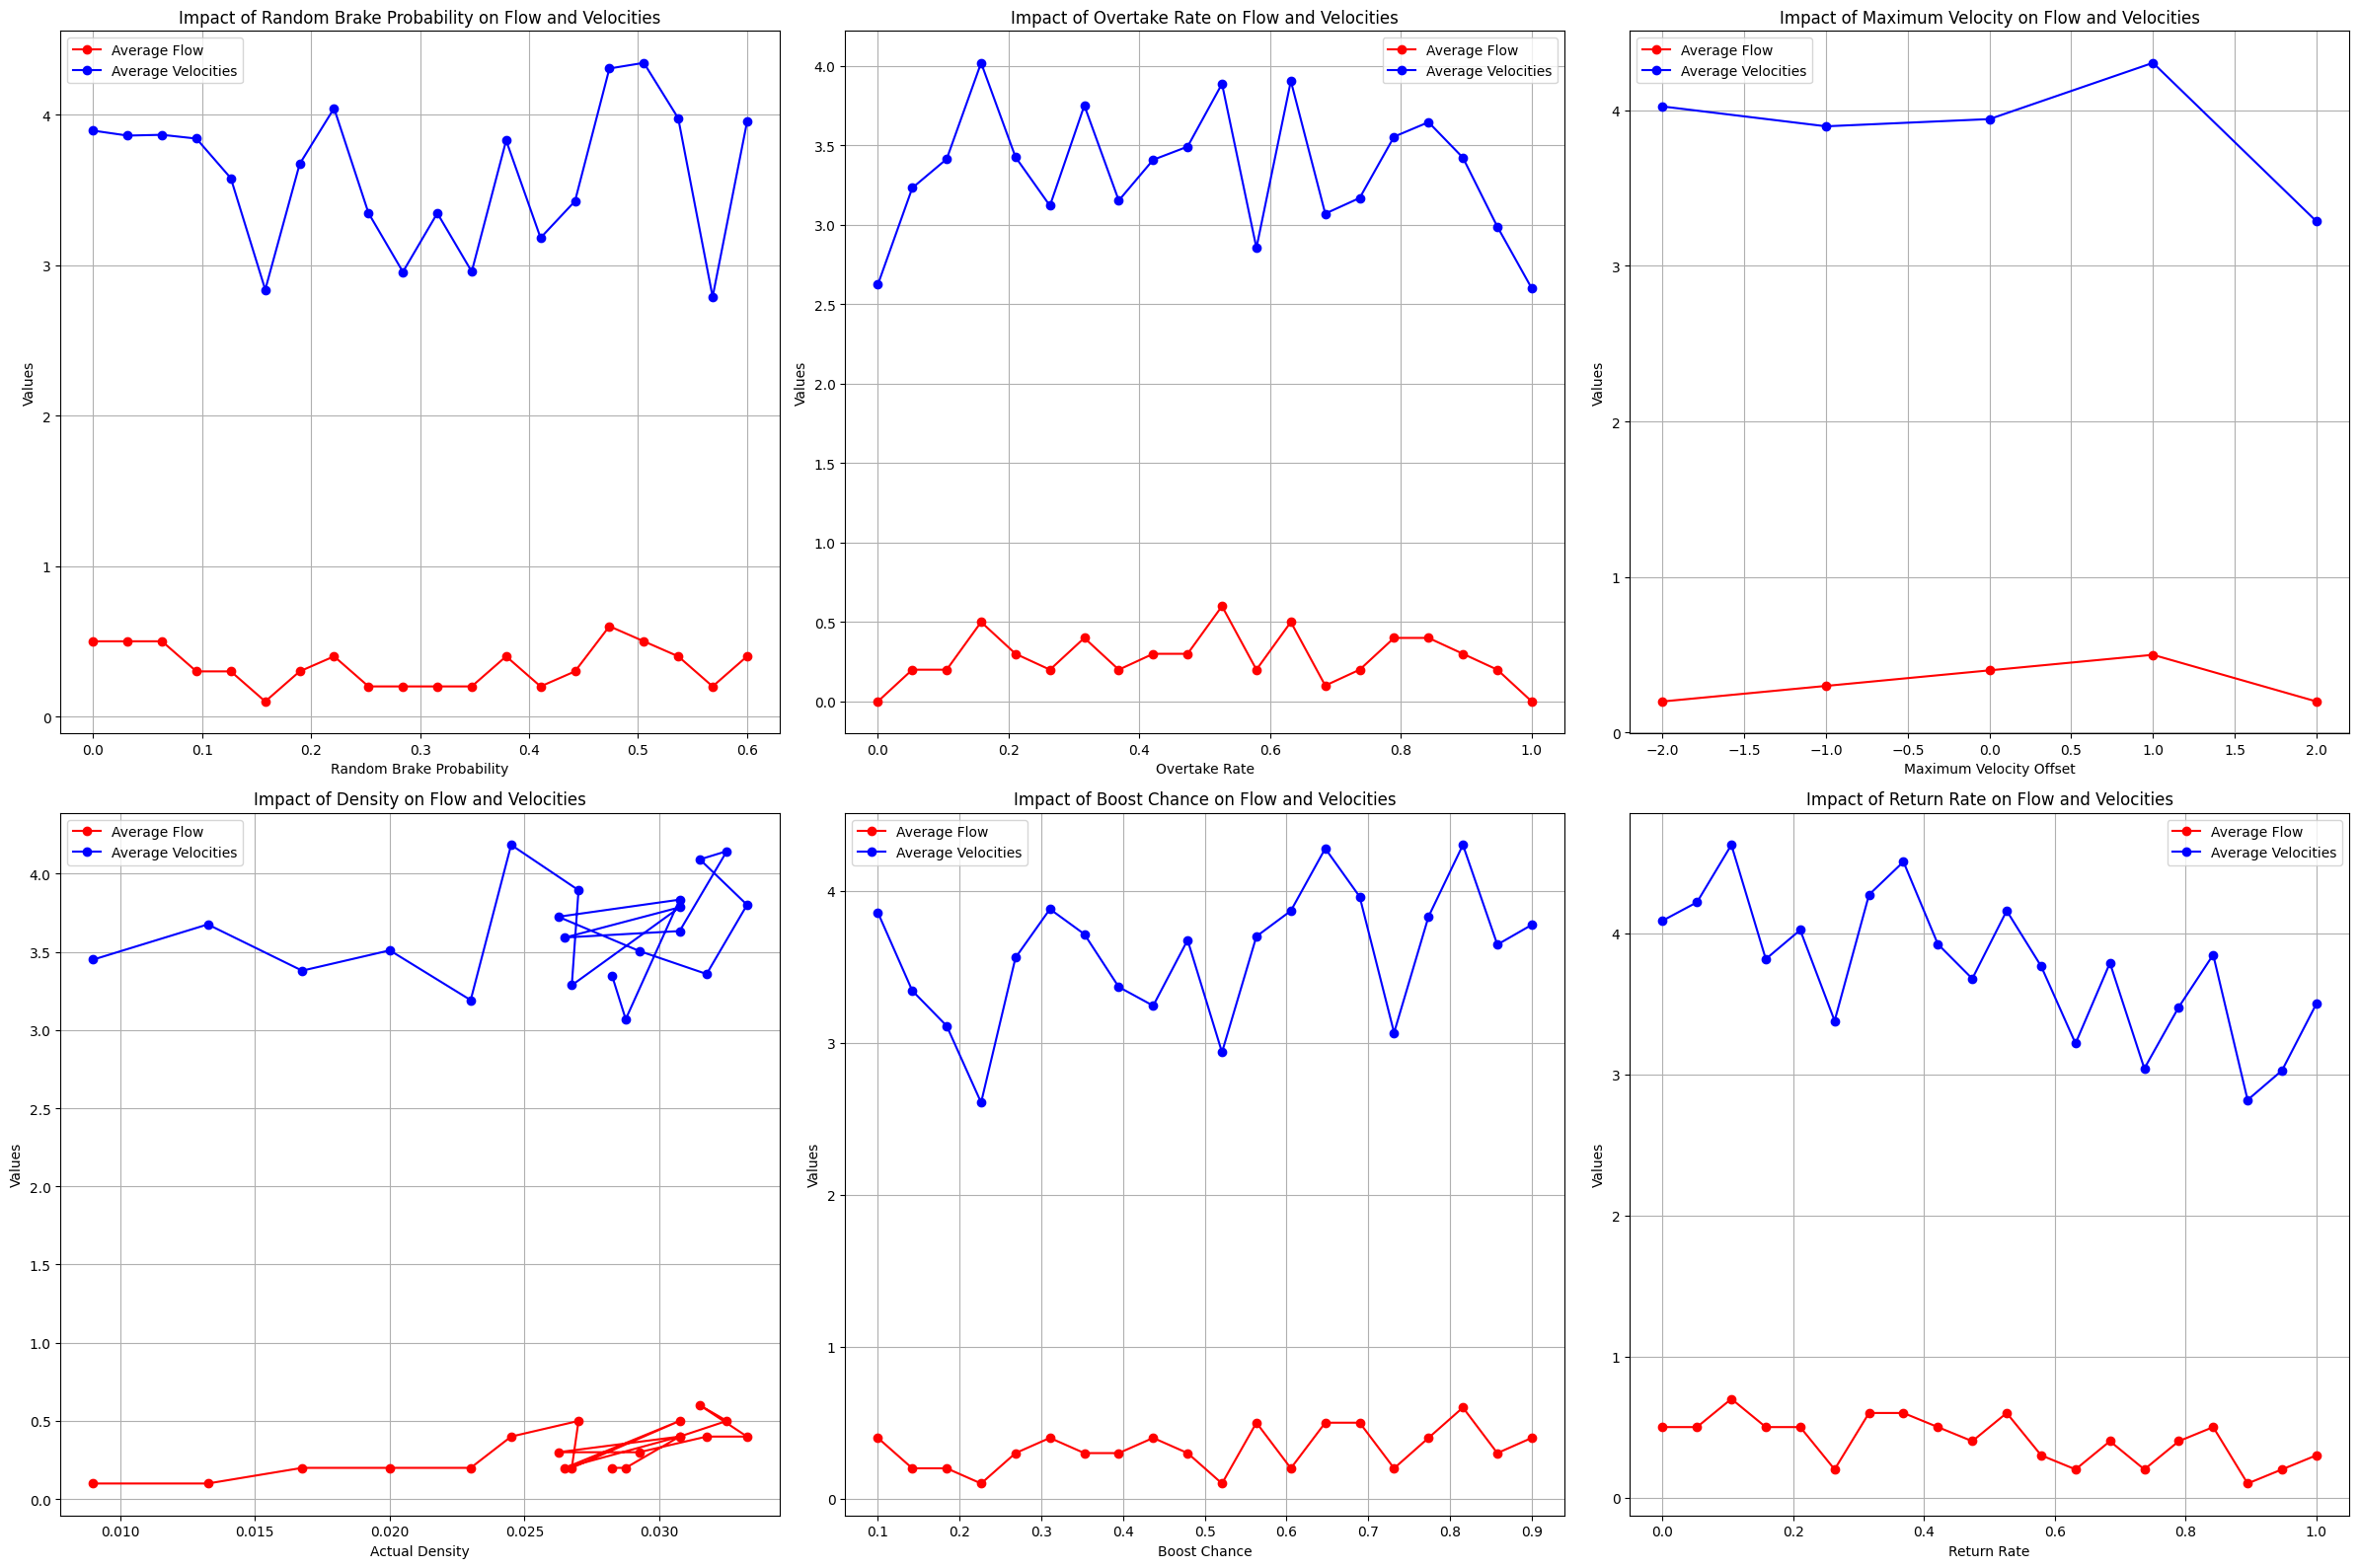

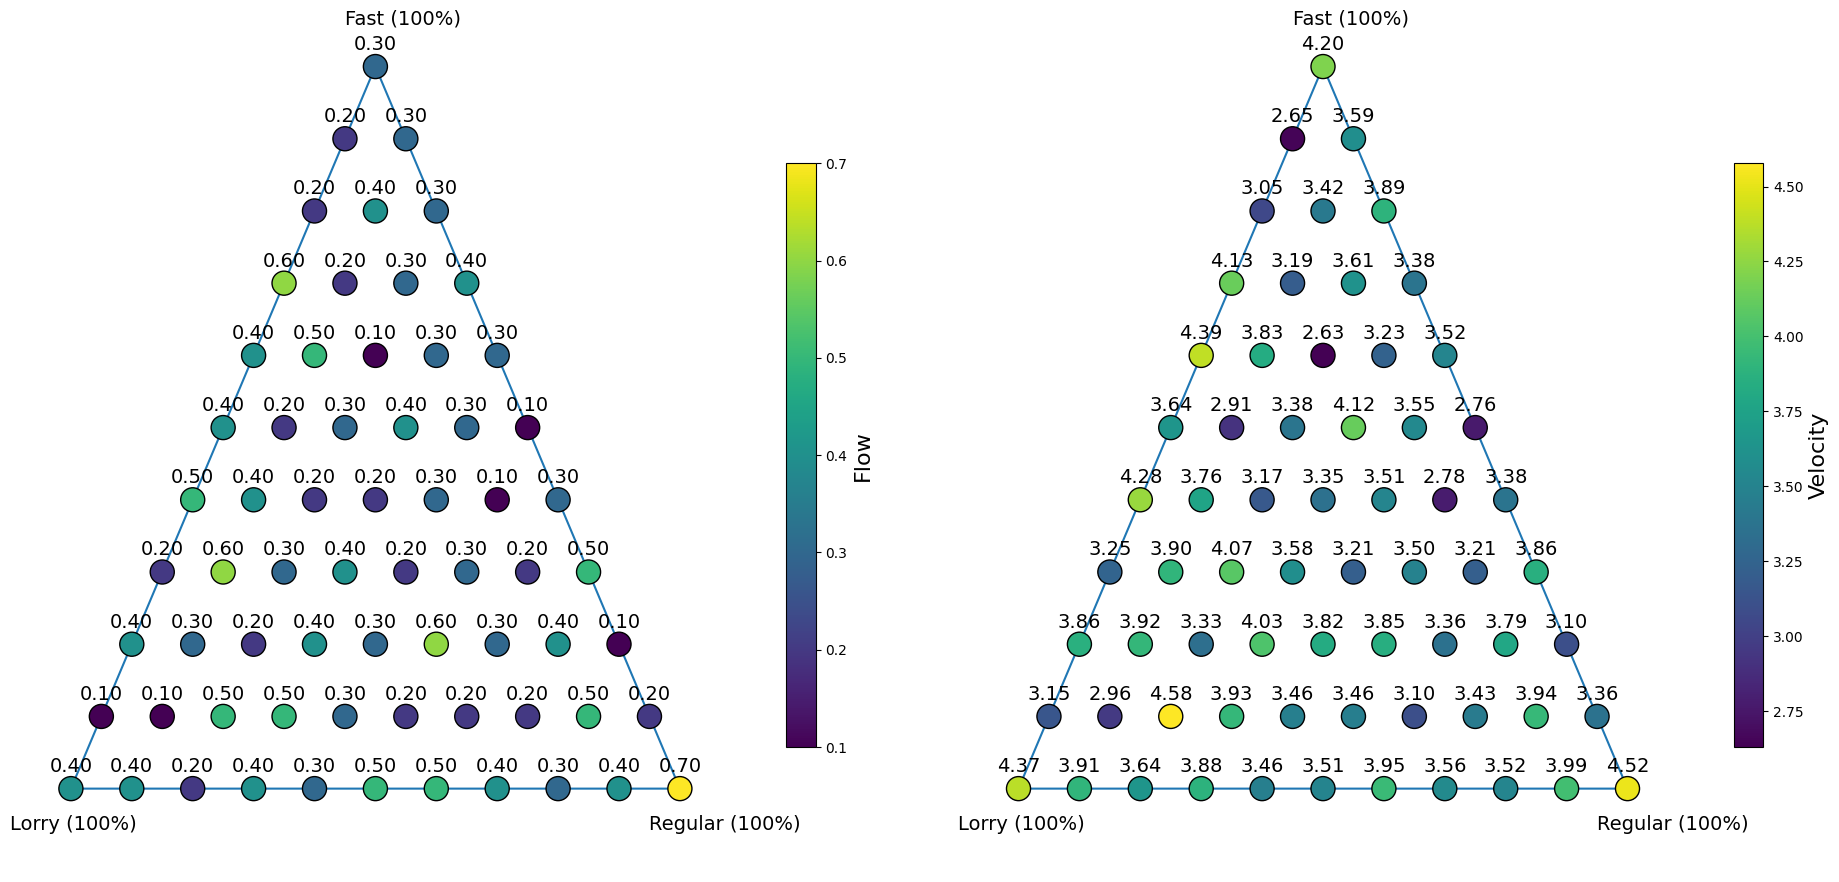

In [ ]:
# run sensitivity analysis for different parameters
#np.random.seed(2532)

length = 100   
t0 = 0       
steps = 20   
base_target_density = 0.2  
interval_size = 1 
    
# function for generating vehicle ratio plot
def plot_vehicle_ratio(ratio_results):
    lorry_ratios = [result[0] for result in ratio_results]
    regular_ratios = [result[1] for result in ratio_results]
    fast_ratios = [result[2] for result in ratio_results]
    flow_values = [result[3] for result in ratio_results]
    velocity_values = [result[4] for result in ratio_results]
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    
    # flow
    axs[0].triplot(triangle, '-')
    x_values = []
    y_values = []
    for l, r, f in zip(lorry_ratios, regular_ratios, fast_ratios):
        x = l*corners[0,0] + r*corners[1,0] + f*corners[2,0]
        y = l*corners[0,1] + r*corners[1,1] + f*corners[2,1]
        x_values.append(x)
        y_values.append(y)
        
    cmap = plt.cm.viridis
    
    scatter_flow = axs[0].scatter(x_values, y_values, c=flow_values, cmap=cmap, s=300, edgecolors='k', zorder=3)
    
    cbar1 = plt.colorbar(scatter_flow, ax=axs[0], shrink=0.7)
    cbar1.set_label('Flow', fontsize=16)
    
    # adding labels
    axs[0].text(corners[0,0]-0.1, corners[0,1]-0.05, 'Lorry (100%)', fontsize=14)
    axs[0].text(corners[1,0]-0.05, corners[1,1]-0.05, 'Regular (100%)', fontsize=14)
    axs[0].text(corners[2,0]-0.05, corners[2,1]+0.05, 'Fast (100%)', fontsize=14)
    
    # adding flow values
    for (x, y, flow) in zip(x_values, y_values, flow_values):
        axs[0].text(x, y+0.02, f'{flow:.2f}', ha='center', fontsize=14)

    axs[0].set_xlim(-0.1, 1.1)
    axs[0].set_ylim(-0.1, 0.9)
    axs[0].axis('off')
     
     
    # velocities
    axs[1].triplot(triangle, '-')
    scatter_velocity = axs[1].scatter(x_values, y_values, c=velocity_values, cmap=cmap, s=300, edgecolors='k', zorder=3)
    
    cbar2 = plt.colorbar(scatter_velocity, ax=axs[1], shrink=0.7)
    cbar2.set_label('Velocity', fontsize=16)

    
    # adding labels
    axs[1].text(corners[0,0]-0.1, corners[0,1]-0.05, 'Lorry (100%)', fontsize=14)
    axs[1].text(corners[1,0]-0.05, corners[1,1]-0.05, 'Regular (100%)', fontsize=14)
    axs[1].text(corners[2,0]-0.05, corners[2,1]+0.05, 'Fast (100%)', fontsize=14)
    
    # adding velocity values
    for (x, y, vel) in zip(x_values, y_values, velocity_values):
        axs[1].text(x, y+0.02, f'{vel:.2f}', ha='center', fontsize=14)

    axs[1].set_xlim(-0.1, 1.1)
    axs[1].set_ylim(-0.1, 0.9)
    axs[1].axis('off')
     
    plt.tight_layout(pad=5.0, w_pad=4.0)
    plt.savefig('vehicle_ratio_ternary.png')
    
    return

# sensitive analysis
def run_sensitivity_analysis():
    # parameter ranges
    random_brake_params = np.linspace(0, 0.6, 20)  
    overtake_params = np.linspace(0, 1, 20)      
    vmax_offsets = [-2, -1, 0, 1, 2]             
    density_params = np.linspace(0.01, 0.09, 20)
    boost_chance_params = np.linspace(0.1, 0.9, 20)
    return_rate_params = np.linspace(0, 1, 20)
    ratio_combinations = []
    
    for i in range(0, 11):
        for j in range(0, 11 - i):
            k = 10 - i - j
            ratio_combinations.append((round(i * 0.1, 1), round(j * 0.1, 1), round(k * 0.1, 1)))
            
    # stor results
    random_brake_results = []
    overtake_results = []
    vmax_results = []
    density_results = []
    actual_densities = []
    boost_chance_results = []
    return_rate_results = []
    ratio_results = []
    
    random_brake_velocities = []
    overtake_velocities = []
    vmax_velocities = []
    density_velocities = []
    boost_chance_velocities = []
    return_rate_velocities = []
    
    # effect of random braking probability
    for random_brake in random_brake_params:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        for vehicle_type in modified_driver_types.values():
            vehicle_type['random_brake_chance'] = random_brake
            
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        random_brake_results.append(avg_flow)
        random_brake_velocities.append(avg_velocities)
        print(f"Random brake chance = {random_brake:.4f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of overtake rate
    for overtake_rate in overtake_params:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        for vehicle_type in modified_driver_types.values():
            vehicle_type['overtake_rate'] = overtake_rate
        
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        overtake_results.append(avg_flow)
        overtake_velocities.append(avg_velocities)
        print(f"Overtake rate = {overtake_rate:.4f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of maximum velocity
    for vmax_offset in vmax_offsets:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        
        for vehicle_type in modified_driver_types.values():
            original_vmax = vehicle_type['vmax']
            vehicle_type['vmax'] = original_vmax + vmax_offset
            vehicle_type['boosted_vmax'] = vehicle_type['boosted_vmax'] + vmax_offset
        
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        vmax_results.append(avg_flow)
        vmax_velocities.append(avg_velocities)
        print(f"Vmax offset = {vmax_offset}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of target density
    for density in density_params:
        flows, densities, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, density, interval_size, 
            driver_types_dict=DRIVER_TYPES)
        
        avg_flow = np.mean(flows)
        actual_density = np.mean(densities)
        avg_velocities = np.mean(velocities)
        
        actual_densities.append(actual_density)
        density_results.append(avg_flow)
        density_velocities.append(avg_velocities)
        print(f"Actual density = {actual_density:.4f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of boost chance
    for boost_chance in boost_chance_params:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        for vehicle_type in modified_driver_types.values():
            vehicle_type['boost_chance'] = boost_chance
        
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        
        boost_chance_results.append(avg_flow)
        boost_chance_velocities.append(avg_velocities)
        print(f"Boost chance = {boost_chance:.4f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of return rate
    for return_rate in return_rate_params:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        for vehicle_type in modified_driver_types.values():
            vehicle_type['return_rate'] = return_rate
        
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        
        return_rate_results.append(avg_flow)
        return_rate_velocities.append(avg_velocities)
        print(f"Return rate = {return_rate:.4f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    # effect of ratio
    for lorry_ratio, regular_ratio, fast_ratio in ratio_combinations:
        modified_driver_types = copy.deepcopy(DRIVER_TYPES)
        
        modified_driver_types[0]['spawn_weight'] = lorry_ratio
        modified_driver_types[1]['spawn_weight'] = regular_ratio
        modified_driver_types[2]['spawn_weight'] = fast_ratio
        
        flows, _, velocities, _ = simulate_traffic_with_density_control(
            length, t0, steps, base_target_density, interval_size, 
            driver_types_dict=modified_driver_types)
        
        avg_flow = np.mean(flows)
        avg_velocities = np.mean(velocities)
        ratio_results.append((lorry_ratio, regular_ratio, fast_ratio, avg_flow, avg_velocities))
        print(f"Lorry={lorry_ratio:.1f}, Regular={regular_ratio:.1f}, Fast={fast_ratio:.1f}, Average flow = {avg_flow:.4f}, Average velocities = {avg_velocities:.4f}")
    
    fig, axs = plt.subplots(2, 3, figsize=(24, 16))
    
    # brake
    axs[0,0].plot(random_brake_params, random_brake_results, 'o-', label='Average Flow', color='red')
    axs[0,0].plot(random_brake_params, random_brake_velocities, 'o-', label='Average Velocities', color='blue')
    axs[0,0].set_xlabel('Random Brake Probability')
    axs[0,0].set_ylabel('Values')
    axs[0,0].set_title('Impact of Random Brake Probability on Flow and Velocities')
    axs[0,0].grid(True)
    axs[0,0].legend()
    
    # overtake
    axs[0,1].plot(overtake_params, overtake_results, 'o-', label='Average Flow', color='red')
    axs[0,1].plot(overtake_params, overtake_velocities, 'o-', label='Average Velocities', color='blue')
    axs[0,1].set_xlabel('Overtake Rate')
    axs[0,1].set_ylabel('Values')
    axs[0,1].set_title('Impact of Overtake Rate on Flow and Velocities')
    axs[0,1].grid(True)
    axs[0,1].legend()

    # vmax
    axs[0,2].plot(vmax_offsets, vmax_results, 'o-', label='Average Flow', color='red')
    axs[0,2].plot(vmax_offsets, vmax_velocities, 'o-', label='Average Velocities', color='blue')
    axs[0,2].set_xlabel('Maximum Velocity Offset')
    axs[0,2].set_ylabel('Values')
    axs[0,2].set_title('Impact of Maximum Velocity on Flow and Velocities')
    axs[0,2].grid(True)
    axs[0,2].legend()

    # density
    axs[1,0].plot(actual_densities, density_results, 'o-', label='Average Flow', color='red')
    axs[1,0].plot(actual_densities, density_velocities, 'o-', label='Average Velocities', color='blue')
    axs[1,0].set_xlabel('Actual Density')
    axs[1,0].set_ylabel('Values')
    axs[1,0].set_title('Impact of Density on Flow and Velocities')
    axs[1,0].grid(True)
    axs[1,0].legend()

    # boost
    axs[1,1].plot(boost_chance_params, boost_chance_results, 'o-', label='Average Flow', color='red')
    axs[1,1].plot(boost_chance_params, boost_chance_velocities, 'o-', label='Average Velocities', color='blue')
    axs[1,1].set_xlabel('Boost Chance')
    axs[1,1].set_ylabel('Values')
    axs[1,1].set_title('Impact of Boost Chance on Flow and Velocities')
    axs[1,1].grid(True)
    axs[1,1].legend()

    # return
    axs[1,2].plot(return_rate_params, return_rate_results, 'o-', label='Average Flow', color='red')
    axs[1,2].plot(return_rate_params, return_rate_velocities, 'o-', label='Average Velocities', color='blue')
    axs[1,2].set_xlabel('Return Rate')
    axs[1,2].set_ylabel('Values')
    axs[1,2].set_title('Impact of Return Rate on Flow and Velocities')
    axs[1,2].grid(True)
    axs[1,2].legend()
    
    
    plt.tight_layout()
    plt.savefig('sensitivity_analysis_results.png')
    
    plot_vehicle_ratio(ratio_results)

    return 

run_sensitivity_analysis()

In [ ]:
# # see how brake chance influence
# np.random.seed(2532)

# def compare_brake_chances():
#     length = 1000   
#     t0 = 1000       
#     steps = 2000     
#     interval_size = 20  
    
    
#     brake_chances = [0.0, 0.1, 0.3, 0.5]
#     target_densities = np.linspace(0.01, 0.1, 15)
#     all_results = {}
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
#     colors = ['blue', 'green', 'red', 'purple']
#     markers = ['o', 's', '^', 'D']
    
#     for i, brake_chance in enumerate(tqdm(brake_chances,desc="Simulating")):
#         avg_velocities = []
#         avg_densities = []
#         avg_flows = []
#         avg_lane_changes = []
        
#         for target_density in target_densities:
#             flows, densities, velocities, lane_change_rates = simulate_traffic_with_density_control(
#                 length=length,
#                 t0=t0,
#                 steps=steps,
#                 target_density=target_density,
#                 interval_size=interval_size,
#                 random_brake_override=brake_chance,
#                 driver_types_dict=None
#             )
            
#             avg_velocity = np.mean(velocities)
#             avg_density = np.mean(densities)
#             avg_flow = np.mean(flows)
#             avg_lane_change = np.mean(lane_change_rates) if lane_change_rates else 0
            
#             avg_velocities.append(avg_velocity)
#             avg_densities.append(avg_density)
#             avg_flows.append(avg_flow)
#             avg_lane_changes.append(avg_lane_change)
              
#         ax1.scatter(
#             avg_densities, 
#             avg_velocities, 
#             color=colors[i], 
#             marker=markers[i],
#             label=f'probability of random brake = {brake_chance}'
#         )
        
#         z = np.polyfit(avg_densities, avg_velocities, 3)
#         p = np.poly1d(z)
#         x_range = np.linspace(min(avg_densities), max(avg_densities), 100)
#         ax1.plot(x_range, p(x_range), color=colors[i], linestyle='--')

            
#         ax2.scatter(
#             avg_densities, 
#             avg_flows, 
#             color=colors[i], 
#             marker=markers[i],
#             label=f'probability of random brake = {brake_chance}'
#         )

#         z = np.polyfit(avg_densities, avg_flows, 3)
#         p = np.poly1d(z)
#         x_range = np.linspace(min(avg_densities), max(avg_densities), 100)
#         ax2.plot(x_range, p(x_range), color=colors[i], linestyle='--')
        
#         ax3.scatter(
#             avg_densities, 
#             avg_lane_changes, 
#             color=colors[i], 
#             marker=markers[i],
#             label=f'probability of random brake = {brake_chance}'
#         )
        

#         z = np.polyfit(avg_densities, avg_lane_changes, 3)
#         p = np.poly1d(z)
#         x_range = np.linspace(min(avg_densities), max(avg_densities), 100)
#         ax3.plot(x_range, p(x_range), color=colors[i], linestyle='--')

            
#     ax1.set_xlabel('Density')
#     ax1.set_ylabel('Speed')
#     ax1.set_title('Speed-Density Relationship')
#     ax1.grid(True, linestyle='--', alpha=0.7)
#     ax1.legend()

#     ax2.set_xlabel('Density')
#     ax2.set_ylabel('Flow')
#     ax2.set_title('Flow-Density Relationship')
#     ax2.grid(True, linestyle='--', alpha=0.7)
#     ax2.legend()
    
#     ax3.set_xlabel('Density')
#     ax3.set_ylabel('Lane Change Rate (changes per vehicle)')
#     ax3.set_title('Lane Change Rate-Density Relationship')
#     ax3.grid(True, linestyle='--', alpha=0.7)
#     ax3.legend()
    
#     plt.tight_layout()
#     plt.savefig('traffic_comparison_for_random_brake.png')
#     plt.show()
    
#     return {
#         'avg_densities': avg_densities,
#         'avg_velocities': avg_velocities,
#         'avg_flow': avg_flows,
#         'avg_lane_changes': avg_lane_changes
#     }

# compare_brake_chances()

In [ ]:
# stability analysis

# code for placing obstacle
def place_obstacle(lanes, driver_types, position, lane, obstacle_type=3, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES

    length = len(lanes[0])
    if position < 0 or position >= length:
        raise ValueError("position out of range")
    
    if lane not in [0, 1]:
        raise ValueError("incorrect lane index(have to be 0/1)")
    
    # check if there is a car at obstacle position, if yes, replace it by obstacle
    if lanes[lane][position] != -1:
        print(f"({lane}, {position}) already have a car, so relpace it by obstacle")

    vmax = driver_types_dict[obstacle_type]['vmax']
    lanes[lane][position] = vmax  
    driver_types[lane][position] = obstacle_type
    
    return lanes, driver_types

# calculate congestion measurement
# calculate congestion measurement
def calculate_local_congestion(lanes, center_position, radius):
    length = len(lanes[0])
    
    start_pos = max(0, center_position - radius)
    end_pos = min(length, center_position + radius)
    
    num_vehicle = 0
    velocity_sum = 0
    
    for lane_idx in range(2):
        for pos in range(start_pos, end_pos):
            if lanes[lane_idx][pos] >= 0:
                num_vehicle += 1
                velocity_sum += lanes[lane_idx][pos]
                
    local_area_size = 2 * (end_pos - start_pos) 
    local_density = num_vehicle / local_area_size if local_area_size > 0 else 0
    local_velocity = velocity_sum / num_vehicle if num_vehicle > 0 else 0
    
    return local_density, local_velocity

# main code for simulation
def simulate_traffic_stability_with_obstacle(length, t0, steps, target_density, 
                                           obstacle_start_time, obstacle_position, obstacle_duration, obstacle_lane = 0, obstacle_type=3, measurement_radius=10, interval_size=10, random_brake_override=None, driver_types_dict=None):
    if driver_types_dict is None:
        driver_types_dict = DRIVER_TYPES
        
    lanes = [np.full(length, -1), np.full(length, -1)]  
    driver_types = [np.full(length, -1), np.full(length, -1)]  
    
    global_flows = []
    global_densities = []
    global_velocities = []
    lane_change_rates = []
    
    local_densities = []
    local_velocities = []

    
    lanes_history = []
    
    # first run the code t0 times, and begin the collection of data after the first t0 time steps
    for _ in range(t0):
        lanes, driver_types, _ =  update_traffic_with_density(lanes, driver_types, target_density, random_brake_override, driver_types_dict)
    
    obstacle_active = False
    obstacle_timer = 0
    
    for step in range(steps):
        lanes_history.append(copy.deepcopy(lanes))
        
        # place obstacle at given time at given position
        if step == obstacle_start_time:
            obstacle_active = True
            obstacle_timer = obstacle_duration if obstacle_duration > 0 else float('inf')
            
            lanes, driver_types = place_obstacle(
                lanes, driver_types, obstacle_position, obstacle_lane, 
                obstacle_type, driver_types_dict
            )
        
        lanes, driver_types, num_lane_change = update_traffic_with_density(lanes, driver_types, target_density, random_brake_override, driver_types_dict)
        
        if obstacle_active:
            # update the timer
            if obstacle_timer != float('inf'):
                obstacle_timer -= 1
                if obstacle_timer <= 0:
                    # remove it
                    obstacle_active = False
                    lanes[obstacle_lane][obstacle_position] = -1
                    driver_types[obstacle_lane][obstacle_position] = -1
        
        # global measurement
        if len(lanes_history) > interval_size:
            lanes_history.pop(0)
            

        flow, density, velocity = calculate_traffic_measurements(lanes_history, interval_size)
        global_flows.append(flow)
        global_densities.append(density)
        global_velocities.append(velocity)
        
        # local measurement around obstacle
        local_density, local_velocity= calculate_local_congestion(lanes, obstacle_position, measurement_radius)
        local_densities.append(local_density)
        local_velocities.append(local_velocity)
 

        current_vehicles = sum(sum(lane >= 0) for lane in lanes)
        lane_change_rate = num_lane_change / current_vehicles if current_vehicles > 0 else 0 
        lane_change_rates.append(lane_change_rate)
    
    return {
        "obstacle_start_time" : obstacle_start_time,
        "obstacle_end_time" : obstacle_start_time +  obstacle_duration,
        'global_flows': global_flows,
        'global_densities': global_densities,
        'global_velocities': global_velocities,
        'lane_change_rates': lane_change_rates,
        'local_densities': local_densities,
        'local_velocities': local_velocities
    }

# generate the plot
def plot_obstacle_impact(results):
    time_steps = range(len(results['global_densities']))
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # density
    axs[0].plot(time_steps, results['global_densities'], 'b-', label='Global Density')
    axs[0].plot(time_steps, results['local_densities'], 'r-', label='Local Density')
    
    axs[0].axvline(x=results['obstacle_start_time'], color='k', linestyle='--', label='Obstacle Appear')
    axs[0].axvline(x=results['obstacle_end_time'], color='g', linestyle='--', label='Obstacle Disappear')
    
    axs[0].set_xlabel('time-steps')
    axs[0].set_ylabel('densities')
    axs[0].legend(loc='upper left')
    axs[0].grid(True, alpha=0.3)
    
    # speed
    axs[1].plot(time_steps, results['global_velocities'], 'b-', label='Global Velocity')
    axs[1].plot(time_steps, results['local_velocities'], 'r-', label='Local Velocity')
    
    axs[1].axvline(x=results['obstacle_start_time'], color='k', linestyle='--', label='Obstacle Appear')
    axs[1].axvline(x=results['obstacle_end_time'], color='g', linestyle='--', label='Obstacle Disappear')
    
    axs[1].set_xlabel('time-steps')
    axs[1].set_ylabel('velocities')
    axs[1].legend(loc='upper left')
    axs[1].grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    
    plt.savefig('obstacle_impact.png')
    plt.show()
    
    return



length = 100  
t0 = 100       
steps = 100
target_density = 1     
obstacle_start_time = 50
obstacle_position = 50
obstacle_duration = 20
interval_size = 10  
results = simulate_traffic_stability_with_obstacle(length, t0, steps, target_density, 
                                           obstacle_start_time, obstacle_position, obstacle_duration, obstacle_lane = 0, obstacle_type=3, measurement_radius=10, interval_size=10, random_brake_override=None, driver_types_dict=None)
plot_obstacle_impact(results)


In [ ]:
# code for plotting the gif
# from matplotlib.animation import FuncAnimation, PillowWriter
# import matplotlib.pyplot as plt
# import numpy as np


# road_length = 200
# target_density=0.2
# lanes = [np.full(road_length, -1), np.full(road_length, -1)]  
# driver_types = [np.full(road_length, -1), np.full(road_length, -1)]  

# # Pre-run the simulation
# t0 = 1000
# for _ in range(t0):
#     lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, random_brake_override= None)


# fig, ax = plt.subplots(figsize=(12, 4))
# ax.set_xlim(-2, road_length)  
# ax.set_ylim(-0.1, 0.6)
# ax.yaxis.set_visible(False)

# scatter_lanes = [None, None]
# velocity_texts = []

# def init():
#     # Draw road lanes, slow on top(left)
#     ax.plot([-2, road_length], [0.3, 0.3], 'k-', lw=1)  #slow lane
#     ax.plot([-2, road_length], [0, 0], 'k-', lw=1)      #fast lane
        
#     ax.set_title('Two-Lane Traffic Flow Simulation (Left-hand Traffic)')
    
#     ax.text(road_length/2, 0.5, 'Drive From Left to Right', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
#     ax.text(-2, 0.3, 'Slow Lane (Left)', ha='right', va='center')
#     ax.text(-2, 0, 'Fast Lane (Right)', ha='right', va='center')
    
#     legend_elements = [
#         plt.scatter([], [], c='blue', s=100, label='Lorry(10%)'),
#         plt.scatter([], [], c='green', s=100, label='Regular Cars(70%)'),
#         plt.scatter([], [], c='red', s=100, label='Fast Cars(20%)')
#     ]
#     ax.legend(handles=legend_elements, loc='upper right')

# def animate(frame):
#     global lanes, driver_types, velocity_texts, scatter_lanes
    
#     # to remove staff in last frame
#     for text in velocity_texts:
#         text.remove()
#     velocity_texts = []
    
#     for scatter in scatter_lanes:
#         if scatter:
#             scatter.remove()
#     scatter_lanes = [None, None]

#     lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, random_brake_override= None)
    
#     for lane_idx in range(2):
#         car_positions = np.where(lanes[lane_idx] >= 0)[0]
        
#         if len(car_positions) > 0:
#             y_positions = np.full_like(car_positions, 0.3 - lane_idx * 0.3, dtype=float)
            
#             colors = []
#             for pos in car_positions:
#                 driver_type = driver_types[lane_idx][pos]
#                 if driver_type == 0:
#                     colors.append('blue')
#                 elif driver_type == 1:
#                     colors.append('green')
#                 else:
#                     colors.append('red')
            
#             scatter_lanes[lane_idx] = ax.scatter(car_positions, y_positions, c=colors, s=100)
            
#             for pos, y in zip(car_positions, y_positions):
#                 velocity = lanes[lane_idx][pos]
#                 text = ax.text(pos, y + 0.05, str(velocity), ha='center', va='center', fontsize=8)
#                 velocity_texts.append(text)
    
# anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=200)

# writer = PillowWriter(fps=3)
# anim.save('two_lane_traffic_simulation.gif', writer=writer)
# plt.close()
